## Mapping

In [1]:
# Import packages
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import intake

In [2]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

# Convert the catalog to a df for easier access
cat_df = catalog.df

In [3]:
# Specify search terms to query catalog for CanESM5 data
# activity_id: Selecting CMIP for historical and ScenarioMIP for future projections
activity_ids = ['ScenarioMIP', 'CMIP'] 

# source_id: Models selected earlier
# source_id = ['GFDL-ESM4' ,'MRI-ESM2-0']
source_id = ['CanESM5' ,'CESM2']


# experiment_id: I chose the historical data and the ssp370 projection as my two time experimental configurations
experiment_ids = ['historical', 'ssp370']

# member_id: Changed the ensemble member here because there was more data available
member_id = 'r10i1p1f1'
# member_id = 'r1i1p1f1'


# table_id: Selecting monthly atmospheric data, which is the table that precipitation is stored in. 
table_id = 'Amon'

# variable_id:  surface air temperature
variable_id = ['tas', 'pr'] 

In [4]:
# Search through catalog, store results in "res" variable
res = catalog.search(activity_id=activity_ids, source_id=source_id, 
                     experiment_id=experiment_ids, table_id=table_id, variable_id=variable_id,
                     member_id=member_id)

# Display data frame associated with results
display(res.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2,historical,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190313
1,CMIP,CCCma,CanESM5,historical,r10i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...,NaN,20190429
2,CMIP,CCCma,CanESM5,historical,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...,NaN,20190429
3,ScenarioMIP,CCCma,CanESM5,ssp370,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
4,ScenarioMIP,CCCma,CanESM5,ssp370,r10i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
5,CMIP,NCAR,CESM2,historical,r10i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20200124
6,ScenarioMIP,NCAR,CESM2,ssp370,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/NCAR/CESM2/ss...,NaN,20200528
7,ScenarioMIP,NCAR,CESM2,ssp370,r10i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/NCAR/CESM2/ss...,NaN,20200528


In [5]:
# Read in the historical data file for CESM
hist_tas_cesm = xr.open_zarr(res.df['zstore'][0], storage_options={'anon': True})
hist_pr_cesm = xr.open_zarr(res.df['zstore'][5], storage_options={'anon': True})

# Read in 370 projections for CESM
tas_cesm_370 = xr.open_zarr(res.df['zstore'][6], storage_options={'anon': True})
pr_cesm_370 = xr.open_zarr(res.df['zstore'][7], storage_options={'anon': True})

# Read in the historical data file for GFDL
hist_tas_can = xr.open_zarr(res.df['zstore'][2], storage_options={'anon': True})
hist_pr_can = xr.open_zarr(res.df['zstore'][1], storage_options={'anon': True})

# Read in 370 projections for CAN
tas_can_370 = xr.open_zarr(res.df['zstore'][3], storage_options={'anon': True})
pr_can_370 = xr.open_zarr(res.df['zstore'][4], storage_options={'anon': True})

In [6]:
# Concatenate historical and future projections for CESM
tas_cesm = xr.concat([hist_tas_cesm, tas_cesm_370], dim="time")
pr_cesm = xr.concat([hist_pr_cesm, pr_cesm_370], dim="time")

# Concatenate historical and future projections for CAN
tas_can = xr.concat([hist_tas_can, tas_can_370], dim="time")
pr_can = xr.concat([hist_pr_can, pr_can_370], dim="time")


## Mapping

In [ ]:
# Define min/max bounds for Southeast Asia
region = [92, 141, -11, 28] 
# [lon_min, lon_max, lat_min, lat_max]

# Time periods of interest
per_early = [1975, 2025]
per_late = [2026, 2075]

# Fix datetime format
tas_cesm['time'] = tas_cesm.time.astype('datetime64[ns]')
pr_cesm['time'] = pr_cesm.time.astype('datetime64[ns]')
tas_can['time'] = tas_can.time.astype('datetime64[ns]')
pr_can['time'] = pr_can.time.astype('datetime64[ns]')

# Sort by time for filtering later on
tas_cesm = tas_cesm.sortby('time')
pr_cesm = pr_cesm.sortby('time')
tas_can = tas_can.sortby('time')
pr_can = pr_can.sortby('time')

In [12]:
# Slice the data to the time periods
# CESM tas historical
tas_cesm_hist = tas_cesm.sel(time=slice(str(per_early[0])+"-01-01", str(per_early[1])+"-12-31"))
# CESM tas future
tas_cesm_fut = tas_cesm.sel(time=slice(str(per_late[0])+"-01-01", str(per_late[1])+"-12-31"))

# CESM pr historical
pr_cesm_hist = pr_cesm.sel(time=slice(str(per_early[0])+"-01-01", str(per_early[1])+"-12-31"))
# CESM pr future
pr_cesm_fut = pr_cesm.sel(time=slice(str(per_late[0])+"-01-01", str(per_late[1])+"-12-31"))

# CESM tas historical
tas_can_hist = tas_can.sel(time=slice(str(per_early[0])+"-01-01", str(per_early[1])+"-12-31"))
# can tas future
tas_can_fut = tas_can.sel(time=slice(str(per_late[0])+"-01-01", str(per_late[1])+"-12-31"))

# can pr historical
pr_can_hist = pr_can.sel(time=slice(str(per_early[0])+"-01-01", str(per_early[1])+"-12-31"))
# can pr future
pr_can_fut = pr_can.sel(time=slice(str(per_late[0])+"-01-01", str(per_late[1])+"-12-31"))



In [20]:
# Calculate the annual mean tas for each model and extract values
# tas CESM historical
tas_cesm_hist_mean = tas_cesm_hist.mean(dim="time") - 273.15
tas_cesm_hist_mean_val = tas_cesm_hist_mean.tas.values

# tas CESM future
tas_cesm_fut_mean = tas_cesm_fut.mean(dim="time") - 273.15
tas_cesm_fut_mean_val = tas_cesm_fut_mean.tas.values

# pr CESM historical
pr_cesm_hist_mean = pr_cesm_hist.mean(dim="time")
pr_cesm_hist_mean_val = pr_cesm_hist_mean.pr.values

# pr CESM future
pr_cesm_fut_mean = pr_cesm_fut.mean(dim="time")
pr_cesm_fut_mean_val = pr_cesm_fut_mean.pr.values

# tas can historical
tas_can_hist_mean = tas_can_hist.mean(dim="time") - 273.15
tas_can_hist_mean_val = tas_can_hist_mean.tas.values

# tas can future
tas_can_fut_mean = tas_can_fut.mean(dim="time") - 273.15
tas_can_fut_mean_val = tas_can_fut_mean.tas.values

# pr can historical
pr_can_hist_mean = pr_can_hist.mean(dim="time")
pr_can_hist_mean_val = pr_can_hist_mean.pr.values

# pr can future
pr_can_fut_mean = pr_can_fut.mean(dim="time")
pr_can_fut_mean_val = pr_can_fut_mean.pr.values



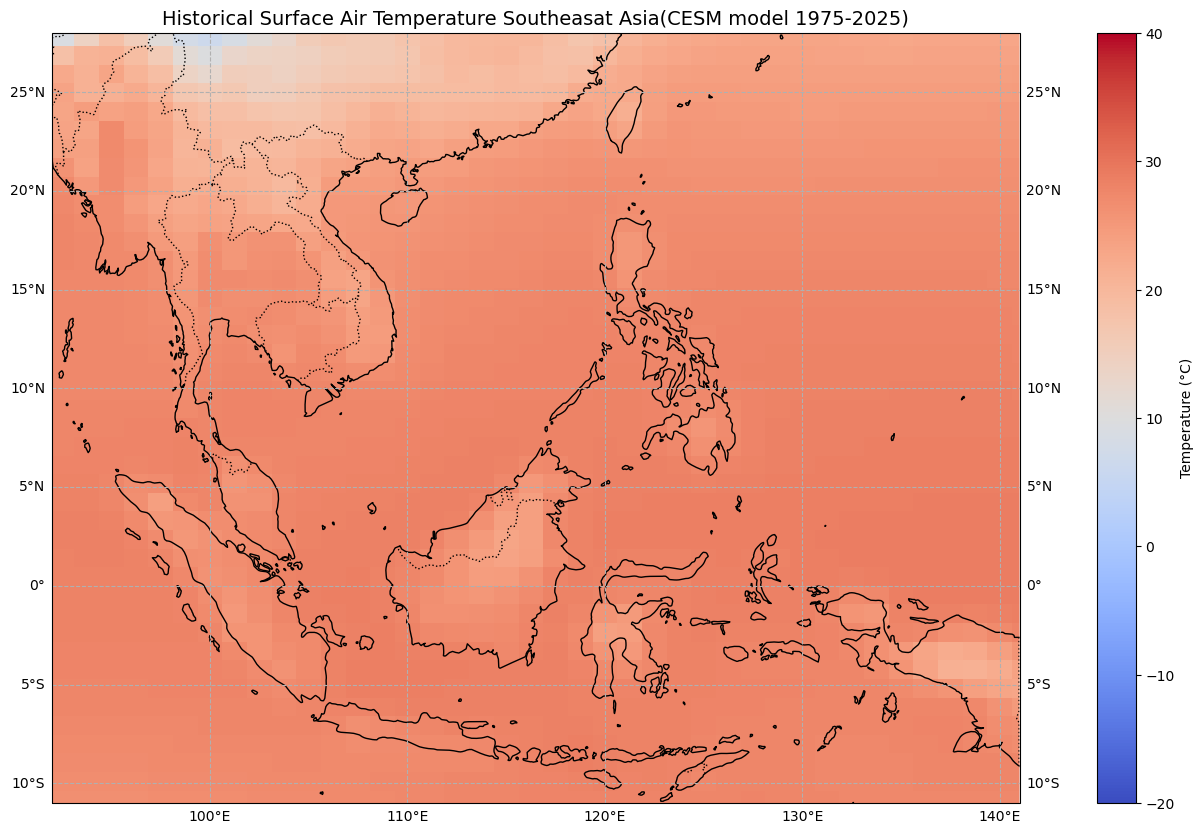

In [21]:
# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(tas_cesm_hist_mean.lon, tas_cesm_hist_mean.lat, tas_cesm_hist_mean_val, 
                     transform=map, cmap="coolwarm", vmin=-20, vmax=40)

# Set spatial extent of plot
ax.set_extent(region, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Historical Surface Air Temperature Southeasat Asia(CESM model 1975-2025)", fontsize= 14)
plt.show()

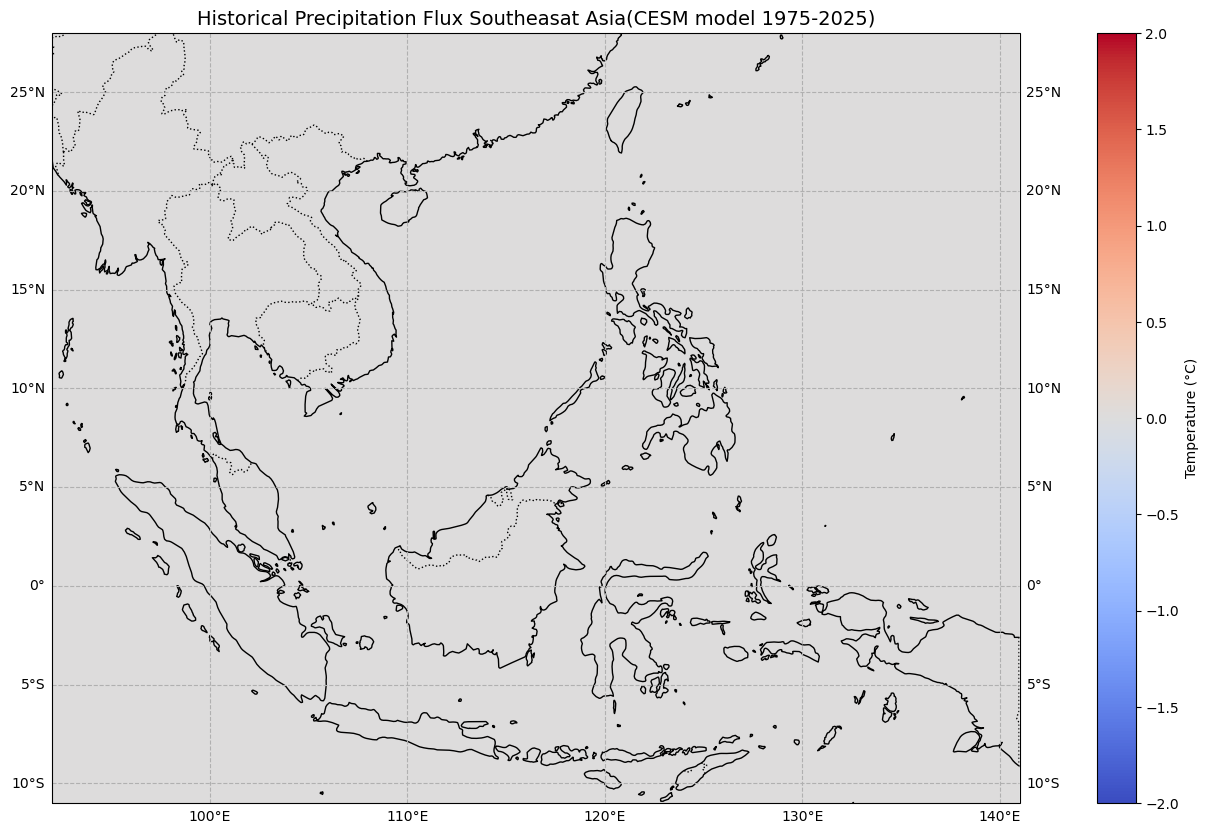

In [26]:
# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(pr_cesm_hist_mean.lon, pr_cesm_hist_mean.lat, pr_cesm_hist_mean_val, 
                     transform=map, cmap="coolwarm", vmin=-2, vmax=2)

# Set spatial extent of plot
ax.set_extent(region, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Historical Precipitation Flux Southeasat Asia(CESM model 1975-2025)", fontsize= 14)
plt.show()

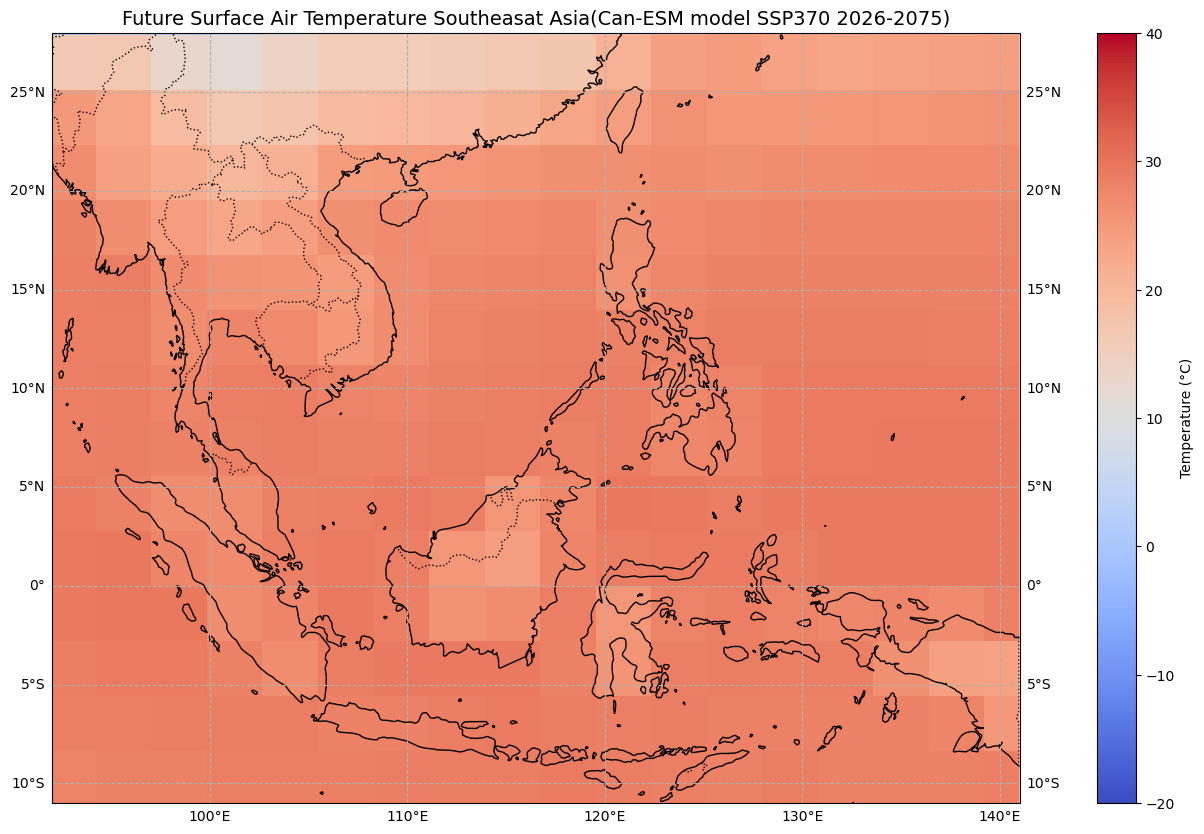

In [27]:
# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(tas_can_hist_mean.lon, tas_can_hist_mean.lat, tas_can_hist_mean_val, 
                     transform=map, cmap="coolwarm", vmin=-20, vmax=40)

# Set spatial extent of plot
ax.set_extent(region, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Future Surface Air Temperature Southeasat Asia(Can-ESM model SSP370 2026-2075)", fontsize= 14)
plt.show()

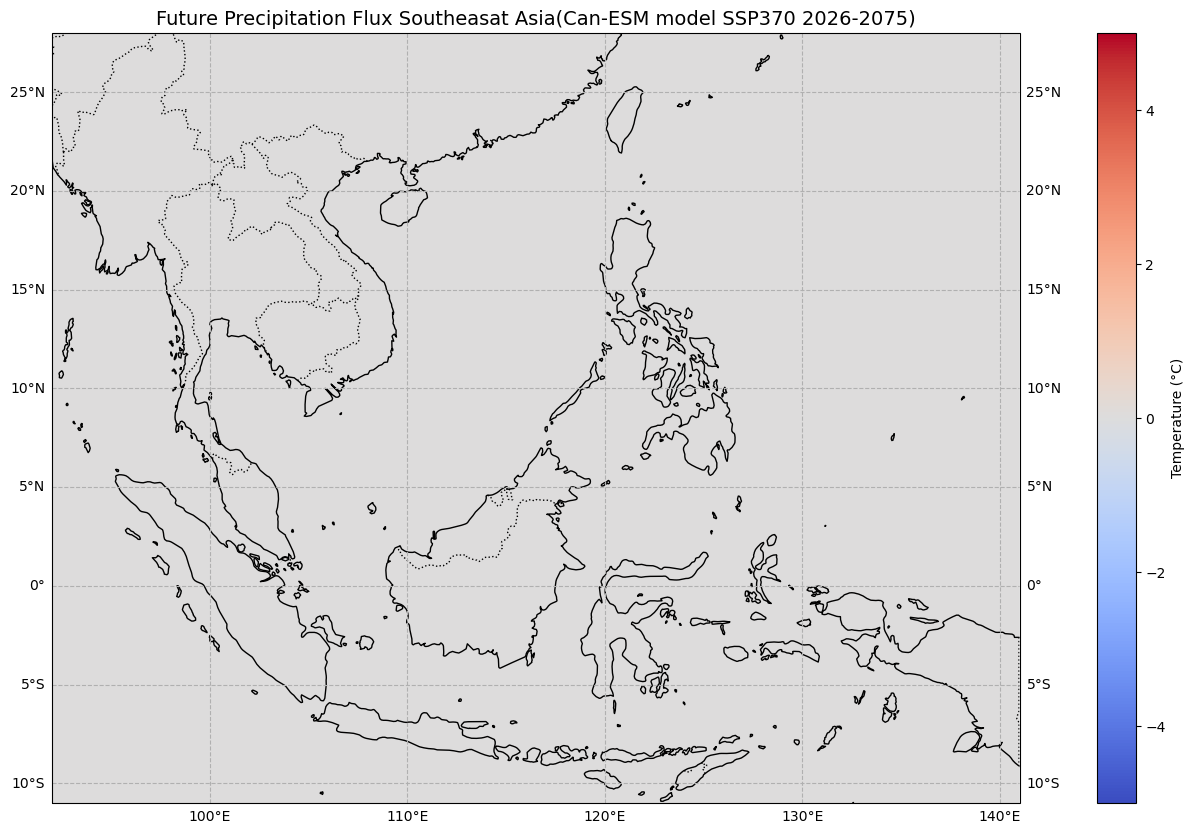

In [29]:
# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(pr_can_hist_mean.lon, pr_can_hist_mean.lat, pr_can_hist_mean_val, 
                     transform=map, cmap="coolwarm", vmin=-5, vmax=5)

# Set spatial extent of plot
ax.set_extent(region, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Future Precipitation Flux Southeasat Asia(Can-ESM model SSP370 2026-2075)", fontsize= 14)
plt.show()